In [2]:
import pandas as pd
import requests
from xml.etree import ElementTree as ET
import time
from urllib.parse import unquote

# 데이터 수집
API_KEY = '7a28b2117e33fd122aa0d30d704e33d65c49f6a39285be38eb56be5fa447154c'
ENDPOINT = 'https://apis.data.go.kr/1613000/RTMSDataSvcAptTradeDev/getRTMSDataSvcAptTradeDev'

all_data = []

print("연수구 2024년 데이터 수집 시작")

for month in range(1, 13):
    deal_ymd = '2024' + str(month).zfill(2)

    params = {
        'serviceKey': unquote(API_KEY),
        'LAWD_CD': '28185',
        'DEAL_YMD': deal_ymd,
        'numOfRows': '10000'
    }

    try:
        response = requests.get(ENDPOINT, params=params, timeout=30)

        if response.status_code == 200:
            root = ET.fromstring(response.text)
            items = root.findall('.//item')

            for item in items:
                data = {
                    '아파트': item.findtext('aptNm', ''),
                    '법정동': item.findtext('umdNm', ''),
                    '전용면적': item.findtext('excluUseAr', ''),
                    '거래금액': item.findtext('dealAmount', ''),
                    '건축년도': item.findtext('buildYear', ''),
                    '층': item.findtext('floor', ''),
                    '거래년': item.findtext('dealYear', ''),
                    '거래월': item.findtext('dealMonth', ''),
                    '거래일': item.findtext('dealDay', ''),
                }
                all_data.append(data)

            print('2024년', month, '월:', len(items), '건')

    except Exception as e:
        print('2024년', month, '월: 오류')

    time.sleep(1.5)

df = pd.DataFrame(all_data)

print('\n총 수집 건수:', len(df))
print('\n데이터 샘플:')
print(df.head())

df.to_csv('incheon_yeonsu_2024.csv', index=False, encoding='utf-8-sig')
print('\n파일 저장 완료: incheon_yeonsu_2024.csv')

연수구 2024년 데이터 수집 시작
2024년 1 월: 347 건
2024년 2 월: 331 건
2024년 3 월: 520 건
2024년 4 월: 433 건
2024년 5 월: 490 건
2024년 6 월: 543 건
2024년 7 월: 626 건
2024년 8 월: 585 건
2024년 9 월: 279 건
2024년 10 월: 355 건
2024년 11 월: 310 건
2024년 12 월: 211 건

총 수집 건수: 5030

데이터 샘플:
             아파트  법정동     전용면적     거래금액  건축년도   층   거래년 거래월 거래일
0  송도푸르지오월드마크1단지  송도동  197.821  175,000  2010  20  2024   1  13
1           용담마을  청학동   49.995   22,400  1994   3  2024   1  24
2            뉴서울  선학동    84.53   33,000  1992   4  2024   1   8
3   송도아메리칸타운아이파크  송도동   64.168   61,000  2018  47  2024   1  30
4    랜드마크시티센트럴더샵  송도동  84.9999   70,800  2020  37  2024   1   9

파일 저장 완료: incheon_yeonsu_2024.csv


In [3]:
import pandas as pd
import numpy as np
# 데이터 전처리
df = pd.read_csv('incheon_yeonsu_2024.csv')

print("원본 데이터 정보")
print(df.info())
print('\n데이터 샘플:')
print(df.head())

print('\n결측치 확인:')
print(df.isnull().sum())

df['거래금액_숫자'] = df['거래금액'].str.replace(',', '').astype(float)
df['전용면적_숫자'] = df['전용면적'].astype(float)
df['층_숫자'] = df['층'].astype(int)
df['건축년도_숫자'] = df['건축년도'].astype(int)

df['평수'] = df['전용면적_숫자'] * 0.3025
df['평당가격'] = df['거래금액_숫자'] / df['평수']
df['건물연령'] = 2024 - df['건축년도_숫자']

df['거래일자'] = pd.to_datetime(df['거래년'].astype(str) + '-' + df['거래월'].astype(str) + '-' + df['거래일'].astype(str))

print('\n전처리 후 데이터:')
print(df.head())
print('\n기본 통계:')
print(df[['거래금액_숫자', '전용면적_숫자', '평수', '평당가격', '건물연령']].describe())

Q1 = df['거래금액_숫자'].quantile(0.25)
Q3 = df['거래금액_숫자'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print(f'\n이상치 범위: {lower:,.0f} ~ {upper:,.0f}만원')
print(f'이상치 개수: {len(df[(df["거래금액_숫자"] < lower) | (df["거래금액_숫자"] > upper)])}건')

df_clean = df[(df['거래금액_숫자'] >= lower) & (df['거래금액_숫자'] <= upper)]

print(f'\n이상치 제거 후: {len(df_clean)}건')

df_clean.to_csv('incheon_yeonsu_2024_cleaned.csv', index=False, encoding='utf-8-sig')
print('\n전처리 완료: incheon_yeonsu_2024_cleaned.csv')

원본 데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5030 entries, 0 to 5029
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   아파트     5030 non-null   object 
 1   법정동     5030 non-null   object 
 2   전용면적    5030 non-null   float64
 3   거래금액    5030 non-null   object 
 4   건축년도    5030 non-null   int64  
 5   층       5030 non-null   int64  
 6   거래년     5030 non-null   int64  
 7   거래월     5030 non-null   int64  
 8   거래일     5030 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 353.8+ KB
None

데이터 샘플:
             아파트  법정동      전용면적     거래금액  건축년도   층   거래년  거래월  거래일
0  송도푸르지오월드마크1단지  송도동  197.8210  175,000  2010  20  2024    1   13
1           용담마을  청학동   49.9950   22,400  1994   3  2024    1   24
2            뉴서울  선학동   84.5300   33,000  1992   4  2024    1    8
3   송도아메리칸타운아이파크  송도동   64.1680   61,000  2018  47  2024    1   30
4    랜드마크시티센트럴더샵  송도동   84.9999   70,800  2020  37  2024    1   

In [4]:
import pandas as pd
import numpy as np
#데이터 분석
df = pd.read_csv('incheon_yeonsu_2024_cleaned.csv')

print("=" * 60)
print("1. 기술 통계")
print("=" * 60)

print("\n거래금액 통계:")
print(f"평균: {df['거래금액_숫자'].mean():,.0f}만원")
print(f"중앙값: {df['거래금액_숫자'].median():,.0f}만원")
print(f"표준편차: {df['거래금액_숫자'].std():,.0f}만원")
print(f"최소값: {df['거래금액_숫자'].min():,.0f}만원")
print(f"최대값: {df['거래금액_숫자'].max():,.0f}만원")

print("\n전용면적 통계:")
print(f"평균: {df['전용면적_숫자'].mean():.2f}m²")
print(f"중앙값: {df['전용면적_숫자'].median():.2f}m²")

print("\n평수 통계:")
print(f"평균: {df['평수'].mean():.2f}평")
print(f"중앙값: {df['평수'].median():.2f}평")

print("\n건축연도별 통계:")
print(df.groupby('건축년도_숫자')['거래금액_숫자'].agg(['count', 'mean']).sort_values('count', ascending=False).head(10))

print("\n" + "=" * 60)
print("2. 시계열 분석")
print("=" * 60)

print("\n월별 평균 거래가 추이:")
monthly_stats = df.groupby('거래월').agg({
    '거래금액_숫자': ['count', 'mean', 'median']
}).round(0)
print(monthly_stats)

print("\n분기별 거래량:")
df['분기'] = df['거래월'].apply(lambda x: f'{(x-1)//3 + 1}분기')
quarterly = df.groupby('분기')['거래금액_숫자'].agg(['count', 'mean'])
print(quarterly)

print("\n계절별 분석 (여름 vs 겨울):")
df['계절'] = df['거래월'].apply(lambda x: '여름' if x in [6,7,8] else ('겨울' if x in [12,1,2] else '봄가을'))
season = df.groupby('계절')['거래금액_숫자'].agg(['count', 'mean'])
print(season)

print("\n" + "=" * 60)
print("3. 지역별 비교")
print("=" * 60)

print("\n법정동별 평균 거래가:")
dong_stats = df.groupby('법정동').agg({
    '거래금액_숫자': ['count', 'mean'],
    '평당가격': 'mean'
}).round(0)
dong_stats.columns = ['거래건수', '평균거래가', '평균평당가']
print(dong_stats.sort_values('거래건수', ascending=False))

print("\n송도 vs 기타 지역:")
df['지역구분'] = df['법정동'].apply(lambda x: '송도' if x == '송도동' else '기타')
region_comp = df.groupby('지역구분')['거래금액_숫자'].agg(['count', 'mean', 'median'])
print(region_comp)

print("\n" + "=" * 60)
print("4. 면적/층수 분석")
print("=" * 60)

print("\n면적대별 평균 가격:")
df['면적구간'] = pd.cut(df['전용면적_숫자'],
                        bins=[0, 60, 85, 100, 200],
                        labels=['소형(60이하)', '중형(60-85)', '준대형(85-100)', '대형(100이상)'])
area_stats = df.groupby('면적구간', observed=True)['거래금액_숫자'].agg(['count', 'mean', 'median'])
print(area_stats)

print("\n층수 구간별 평균 가격:")
df['층구간'] = pd.cut(df['층_숫자'],
                      bins=[0, 5, 15, 50],
                      labels=['저층(1-5)', '중층(6-15)', '고층(16+)'])
floor_stats = df.groupby('층구간', observed=True)['거래금액_숫자'].agg(['count', 'mean'])
print(floor_stats)

print("\n" + "=" * 60)
print("5. 건물 연령 분석")
print("=" * 60)

print("\n건물연령 구간별:")
df['연령구간'] = pd.cut(df['건물연령'],
                       bins=[0, 5, 10, 20, 50],
                       labels=['신축(5년이하)', '준신축(5-10년)', '중고(10-20년)', '노후(20년이상)'])
age_stats = df.groupby('연령구간', observed=True)['거래금액_숫자'].agg(['count', 'mean'])
print(age_stats)

print("\n신축(5년이하) vs 노후(20년이상) 가격 차이:")
new_price = df[df['건물연령'] <= 5]['거래금액_숫자'].mean()
old_price = df[df['건물연령'] >= 20]['거래금액_숫자'].mean()
print(f"신축 평균: {new_price:,.0f}만원")
print(f"노후 평균: {old_price:,.0f}만원")
print(f"가격 차이: {new_price - old_price:,.0f}만원 ({((new_price/old_price - 1) * 100):.1f}% 높음)")

print("\n" + "=" * 60)
print("6. 주요 인사이트 도출")
print("=" * 60)

print("\n[인사이트 1] 지역별 가격 차이")
songdo_avg = df[df['법정동'] == '송도동']['평당가격'].mean()
other_avg = df[df['법정동'] != '송도동']['평당가격'].mean()
print(f"송도 평당가격: {songdo_avg:,.0f}만원")
print(f"기타지역 평당가격: {other_avg:,.0f}만원")
print(f"→ 송도가 기타지역보다 평당 {songdo_avg - other_avg:,.0f}만원 비쌈")

print("\n[인사이트 2] 거래 활발 시기")
max_month = monthly_stats.idxmax()[0]
print(f"가장 거래 많은 달: {max_month}월 ({monthly_stats.loc[max_month][0]}건)")
min_month = monthly_stats.idxmin()[0]
print(f"가장 거래 적은 달: {min_month}월 ({monthly_stats.loc[min_month][0]}건)")

print("\n[인사이트 3] 선호 평수")
popular_area = df['면적구간'].value_counts().idxmax()
print(f"가장 많이 거래된 면적: {popular_area}")

print("\n[인사이트 4] 층수 선호도")
print(f"고층(16층+) 평균가: {df[df['층_숫자'] >= 16]['거래금액_숫자'].mean():,.0f}만원")
print(f"저층(1-5층) 평균가: {df[df['층_숫자'] <= 5]['거래금액_숫자'].mean():,.0f}만원")

print("\nEDA 완료")

1. 기술 통계

거래금액 통계:
평균: 55,024만원
중앙값: 57,000만원
표준편차: 26,542만원
최소값: 9,500만원
최대값: 138,000만원

전용면적 통계:
평균: 80.20m²
중앙값: 84.69m²

평수 통계:
평균: 24.26평
중앙값: 25.62평

건축연도별 통계:
         count          mean
건축년도_숫자                     
1994       726  31009.807163
1993       554  31719.492780
2018       469  67958.400853
2020       444  67839.977477
2017       325  72693.661538
1992       311  24971.736334
2019       302  60169.470199
1995       192  28638.307292
2015       182  86096.703297
2005       177  60918.361582

2. 시계열 분석

월별 평균 거래가 추이:
    거래금액_숫자                  
      count     mean   median
거래월                          
1       341  48688.0  41500.0
2       326  50831.0  48750.0
3       513  51803.0  49000.0
4       427  57056.0  59800.0
5       485  55680.0  57000.0
6       539  52885.0  54000.0
7       618  57633.0  60700.0
8       575  56367.0  59300.0
9       275  55779.0  57500.0
10      352  59968.0  62475.0
11      305  56641.0  59300.0
12      209  56552.0  59500.0

분기별 거래량:


/tmp/ipython-input-1457207777.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_month = monthly_stats.idxmax()[0]
/tmp/ipython-input-1457207777.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"가장 거래 많은 달: {max_month}월 ({monthly_stats.loc[max_month][0]}건)")
/tmp/ipython-input-1457207777.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_month = monthly_stats.idxmin()[0]
/tmp/ipython-input-1457207777.py:116

시각화 시작


/tmp/ipython-input-3579894115.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_count, x='거래월', y='count', palette='viridis')


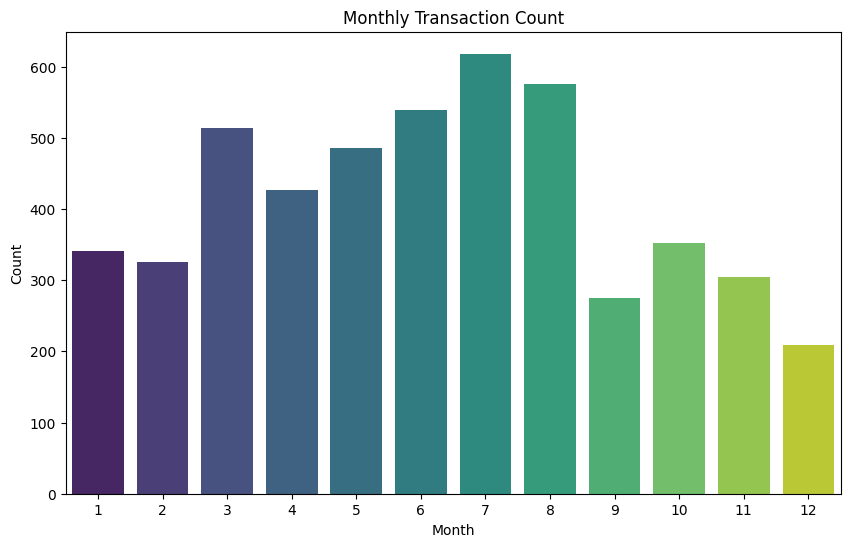

월별 거래 건수


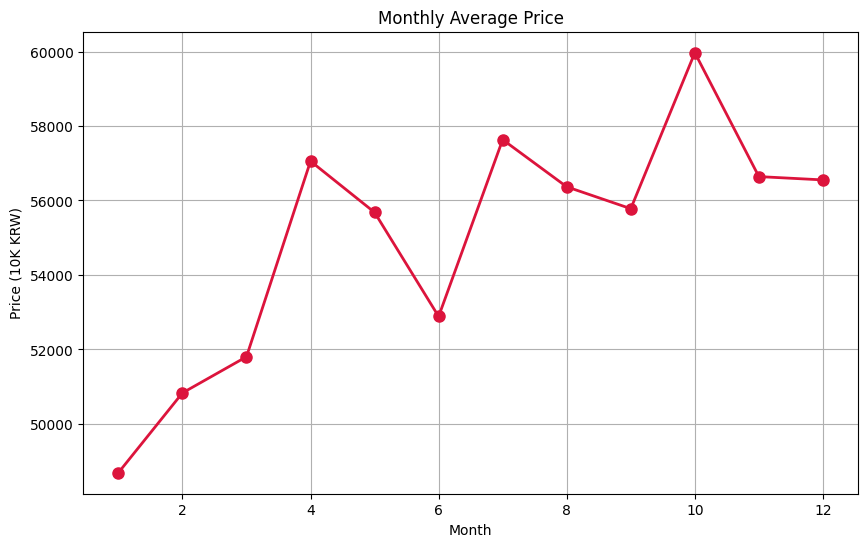

월별 평균 거래가


/tmp/ipython-input-3579894115.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dong_data, x='법정동_영문', y='count', palette='coolwarm')


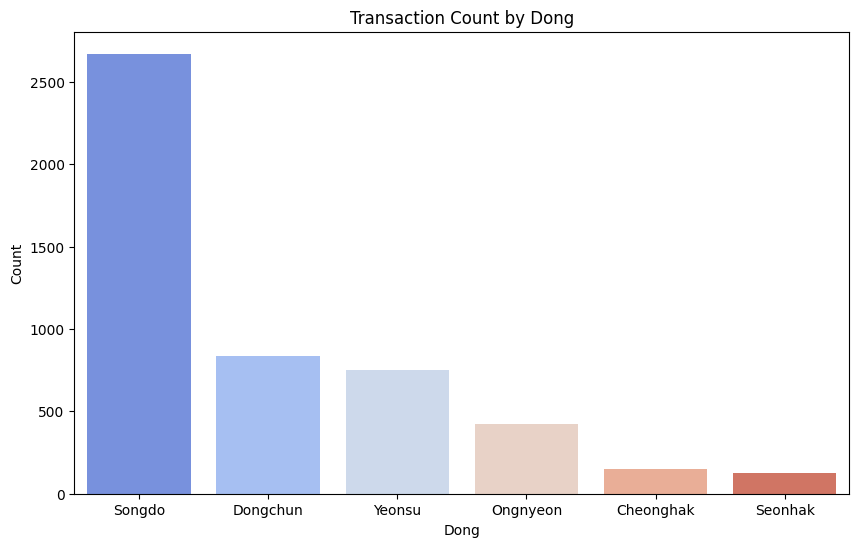

법정동별 거래건수


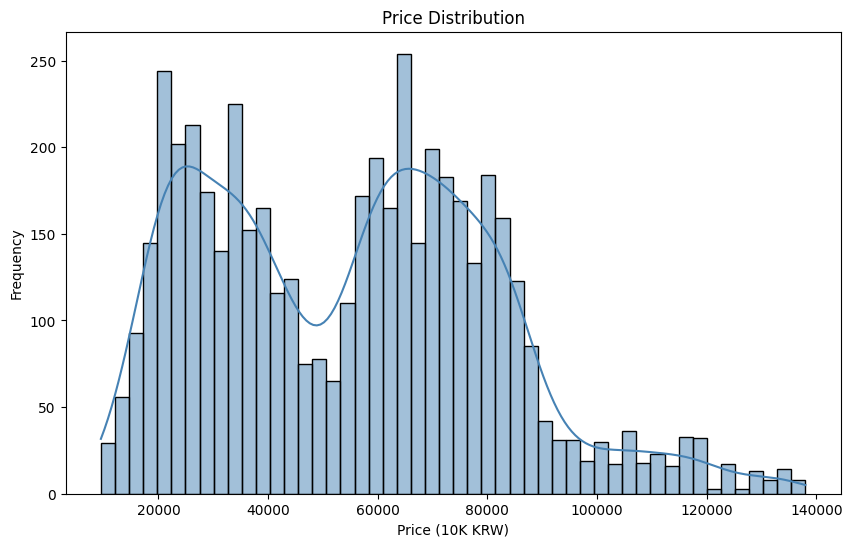

거래금액 분포


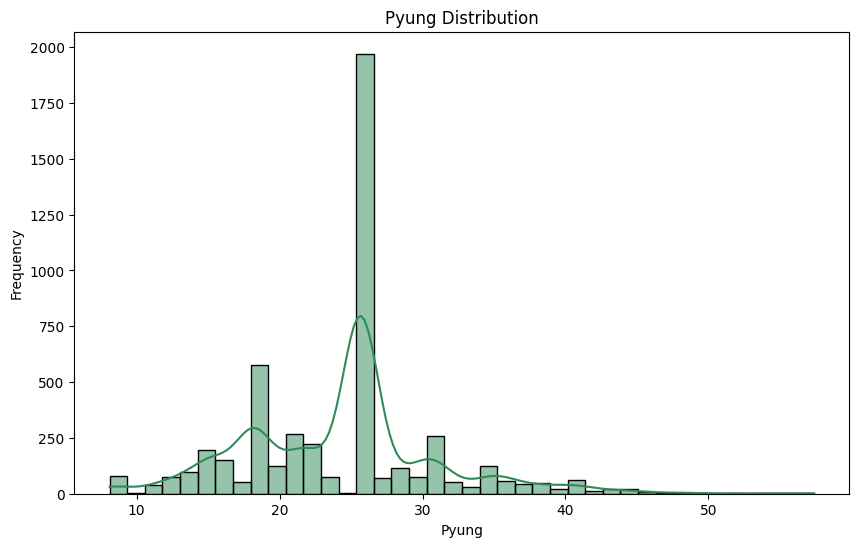

평수 분포


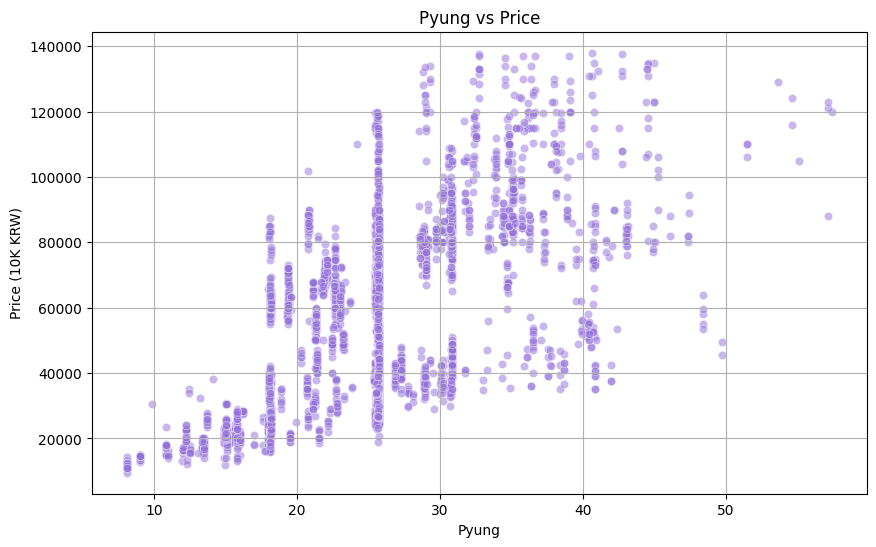

평수 vs 거래금액


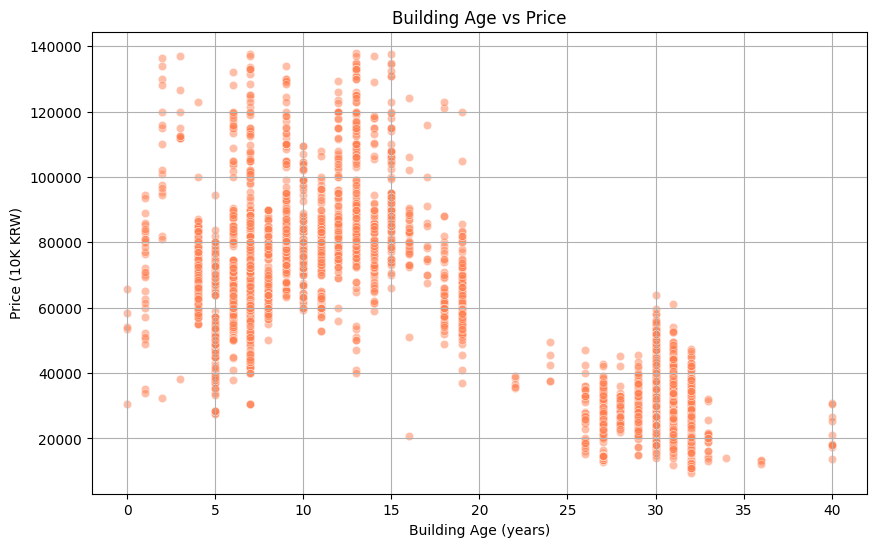

건물연령 vs 거래금액


/tmp/ipython-input-3579894115.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=floor_price, x='층구간', y='거래금액_숫자', palette='magma')


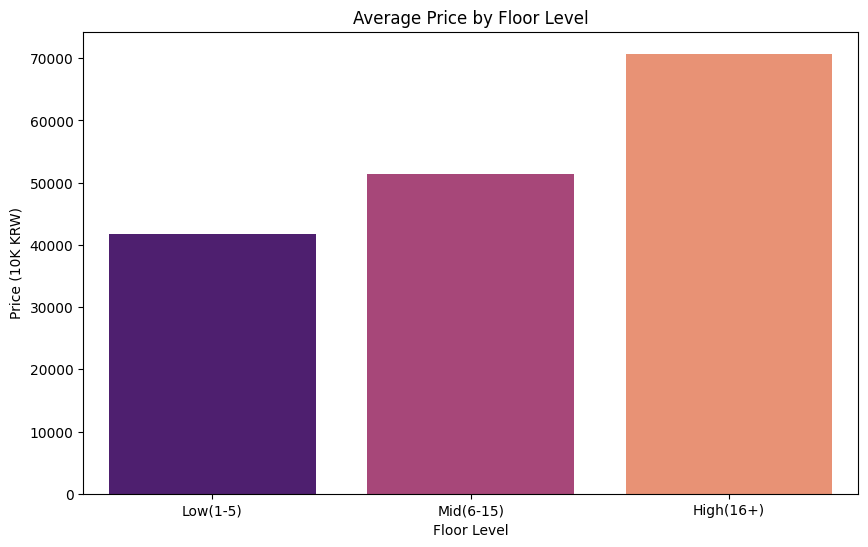

층수별 평균 가격


/tmp/ipython-input-3579894115.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_price, x='지역구분', y='거래금액_숫자', palette=['#FF6B6B', '#4ECDC4'])


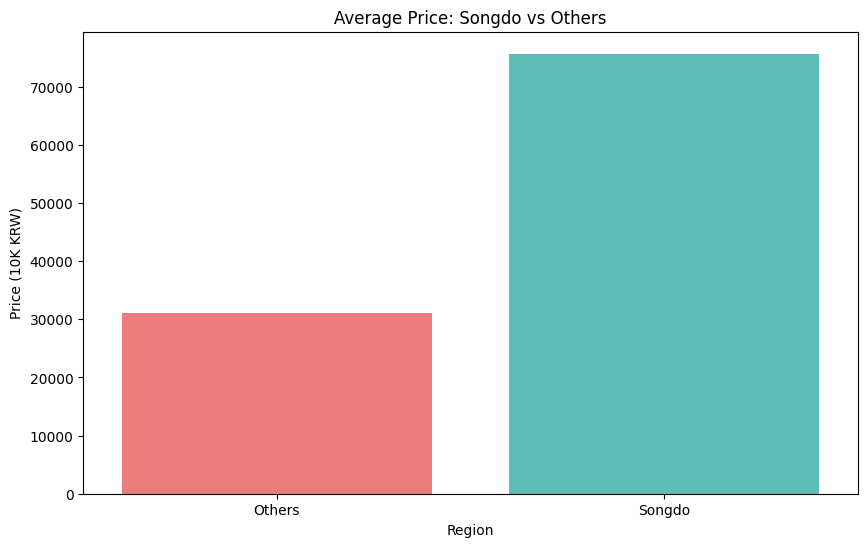

송도 vs 기타지역 비교


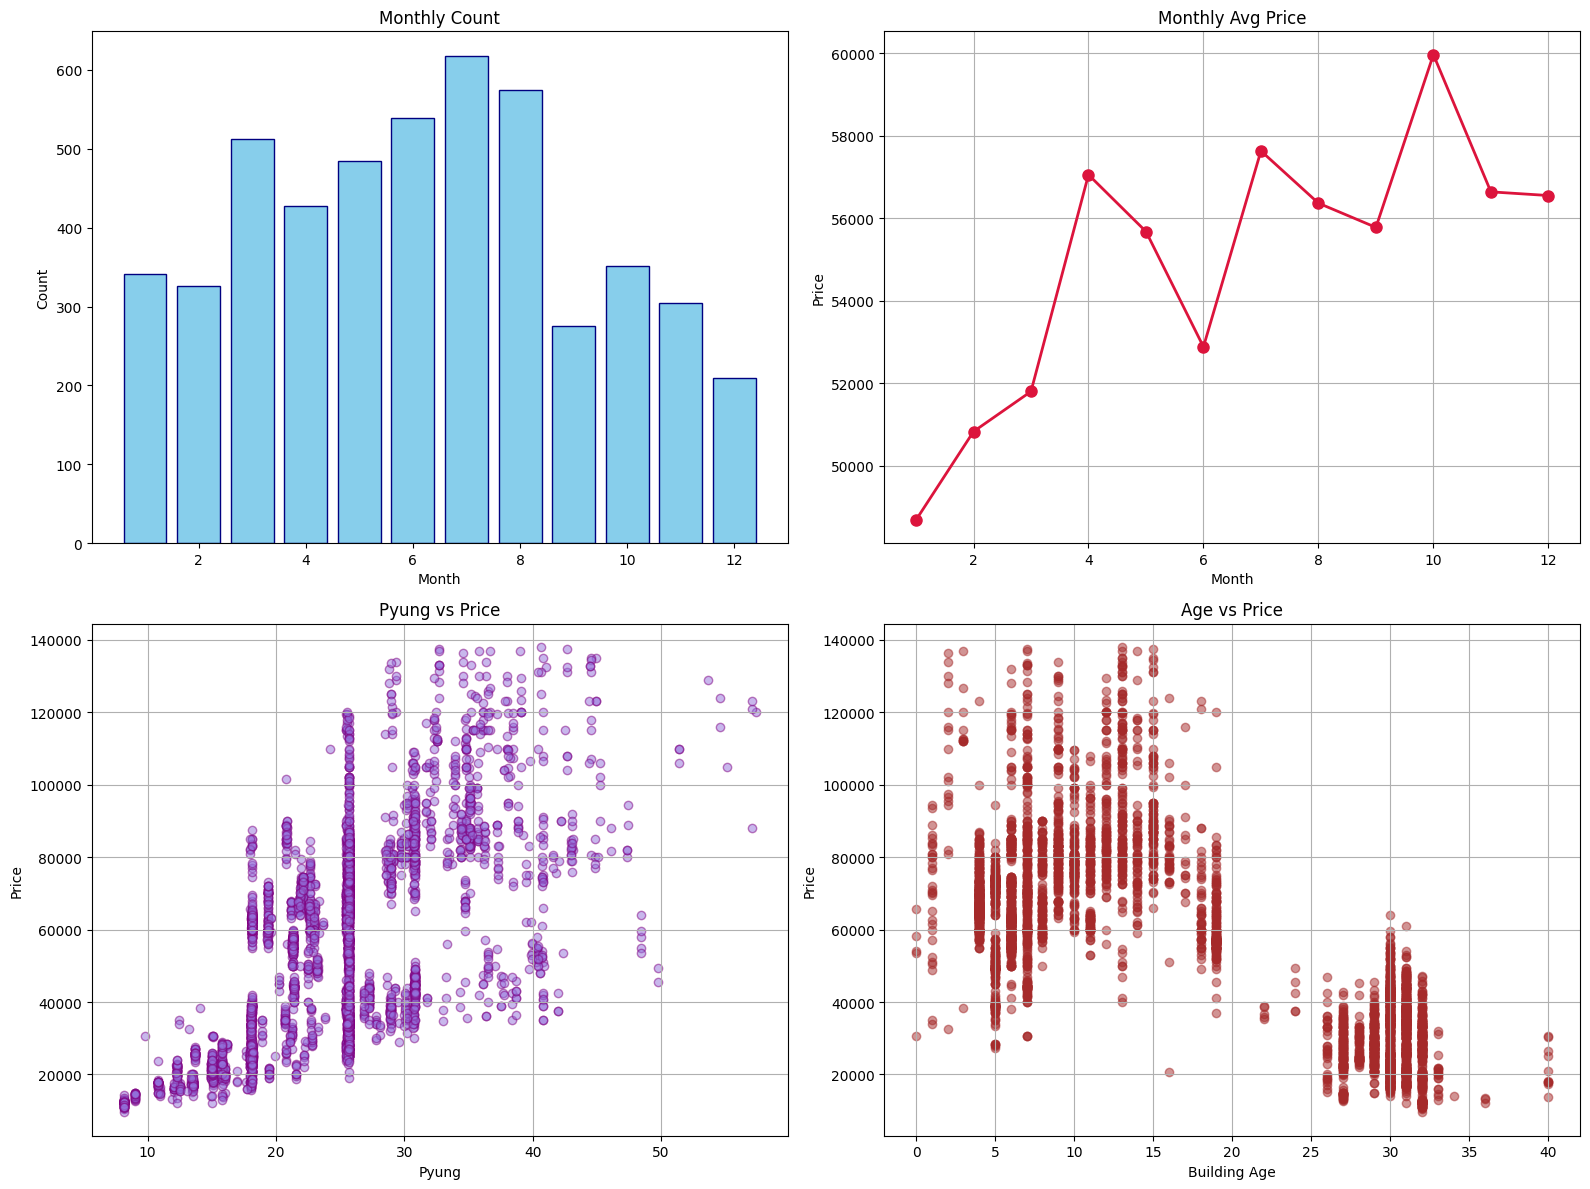

subplot 종합

시각화 완료!


In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

# 데이터 시각화
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

df = pd.read_csv('incheon_yeonsu_2024_cleaned.csv')

print("시각화 시작")

# 1. 월별 거래 건수 - barplot
plt.figure(figsize=(10, 6))
monthly_count = df.groupby('거래월').size().reset_index(name='count')
sns.barplot(data=monthly_count, x='거래월', y='count', palette='viridis')
plt.title('Monthly Transaction Count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.savefig('01_monthly_count.png', dpi=300, bbox_inches='tight')
plt.show()
print("월별 거래 건수")

# 2. 월별 평균 거래가 - lineplot
plt.figure(figsize=(10, 6))
monthly_price = df.groupby('거래월')['거래금액_숫자'].mean()
monthly_price.plot(kind='line', marker='o', color='crimson', linewidth=2, markersize=8)
plt.title('Monthly Average Price')
plt.xlabel('Month')
plt.ylabel('Price (10K KRW)')
plt.grid(True)
plt.savefig('02_monthly_price.png', dpi=300, bbox_inches='tight')
plt.show()
print("월별 평균 거래가")

# 3. 법정동별 거래건수 - barplot
plt.figure(figsize=(10, 6))
dong_data = df.groupby('법정동').size().reset_index(name='count').sort_values('count', ascending=False)
# 법정동 이름을 영어로 변환
dong_name_map = {
    '송도동': 'Songdo',
    '연수동': 'Yeonsu',
    '옥련동': 'Ongnyeon',
    '동춘동': 'Dongchun',
    '선학동': 'Seonhak',
    '청학동': 'Cheonghak',
    '문학동': 'Munhak'
}
dong_data['법정동_영문'] = dong_data['법정동'].map(dong_name_map)
sns.barplot(data=dong_data, x='법정동_영문', y='count', palette='coolwarm')
plt.title('Transaction Count by Dong')
plt.xlabel('Dong')
plt.ylabel('Count')
plt.savefig('03_dong_count.png', dpi=300, bbox_inches='tight')
plt.show()
print("법정동별 거래건수")

# 4. 거래금액 분포 - histplot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='거래금액_숫자', kde=True, bins=50, color='steelblue')
plt.title('Price Distribution')
plt.xlabel('Price (10K KRW)')
plt.ylabel('Frequency')
plt.savefig('04_price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("거래금액 분포")

# 5. 평수 분포 - histplot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='평수', kde=True, bins=40, color='seagreen')
plt.title('Pyung Distribution')
plt.xlabel('Pyung')
plt.ylabel('Frequency')
plt.savefig('05_pyung_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("평수 분포")

# 6. 평수 vs 거래금액 - scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='평수', y='거래금액_숫자', alpha=0.5, color='mediumpurple')
plt.title('Pyung vs Price')
plt.xlabel('Pyung')
plt.ylabel('Price (10K KRW)')
plt.grid(True)
plt.savefig('06_pyung_vs_price.png', dpi=300, bbox_inches='tight')
plt.show()
print("평수 vs 거래금액")

# 7. 건물연령 vs 거래금액 - scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='건물연령', y='거래금액_숫자', alpha=0.5, color='coral')
plt.title('Building Age vs Price')
plt.xlabel('Building Age (years)')
plt.ylabel('Price (10K KRW)')
plt.grid(True)
plt.savefig('07_age_vs_price.png', dpi=300, bbox_inches='tight')
plt.show()
print("건물연령 vs 거래금액")

# 8. 층수별 평균 가격 - barplot
plt.figure(figsize=(10, 6))
df['층구간'] = pd.cut(df['층_숫자'], bins=[0, 5, 15, 50], labels=['Low(1-5)', 'Mid(6-15)', 'High(16+)'])
floor_price = df.groupby('층구간', observed=True)['거래금액_숫자'].mean().reset_index()
sns.barplot(data=floor_price, x='층구간', y='거래금액_숫자', palette='magma')
plt.title('Average Price by Floor Level')
plt.xlabel('Floor Level')
plt.ylabel('Price (10K KRW)')
plt.savefig('08_floor_price.png', dpi=300, bbox_inches='tight')
plt.show()
print("층수별 평균 가격")

# 9. 송도 vs 기타지역 비교 - barplot
plt.figure(figsize=(10, 6))
df['지역구분'] = df['법정동'].apply(lambda x: 'Songdo' if x == '송도동' else 'Others')
region_price = df.groupby('지역구분')['거래금액_숫자'].mean().reset_index()
sns.barplot(data=region_price, x='지역구분', y='거래금액_숫자', palette=['#FF6B6B', '#4ECDC4'])
plt.title('Average Price: Songdo vs Others')
plt.xlabel('Region')
plt.ylabel('Price (10K KRW)')
plt.savefig('09_songdo_vs_others.png', dpi=300, bbox_inches='tight')
plt.show()
print("송도 vs 기타지역 비교")

# 10. subplot 종합
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(2, 2, 1)
monthly_count = df.groupby('거래월').size()
ax1.bar(monthly_count.index, monthly_count.values, color='skyblue', edgecolor='navy')
ax1.set_title('Monthly Count')
ax1.set_xlabel('Month')
ax1.set_ylabel('Count')

ax2 = fig.add_subplot(2, 2, 2)
monthly_price = df.groupby('거래월')['거래금액_숫자'].mean()
ax2.plot(monthly_price.index, monthly_price.values, marker='o', color='crimson', linewidth=2, markersize=8)
ax2.set_title('Monthly Avg Price')
ax2.set_xlabel('Month')
ax2.set_ylabel('Price')
ax2.grid(True)

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(df['평수'], df['거래금액_숫자'], alpha=0.5, color='mediumpurple', edgecolors='purple')
ax3.set_title('Pyung vs Price')
ax3.set_xlabel('Pyung')
ax3.set_ylabel('Price')
ax3.grid(True)

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(df['건물연령'], df['거래금액_숫자'], alpha=0.5, color='brown')
ax4.set_title('Age vs Price')
ax4.set_xlabel('Building Age')
ax4.set_ylabel('Price')
ax4.grid(True)

plt.tight_layout()
plt.savefig('10_subplot_combined.png', dpi=300, bbox_inches='tight')
plt.show()
print("subplot 종합")

print("\n시각화 완료!")

머신러닝: 아파트 거래금액 예측 모델

1. 데이터 준비
전체 데이터: 4965건
특성: ['법정동_encoded', '전용면적_숫자', '층_숫자', '건축년도_숫자', '거래월']
타겟: 거래금액_숫자

학습 데이터: 3972건
테스트 데이터: 993건

2. 모델 학습

[1] 선형회귀 학습 중...
RMSE: 11,769만원
MAE: 8,897만원
R2 Score: 0.7975

[2] 랜덤포레스트 학습 중...
RMSE: 4,502만원
MAE: 2,608만원
R2 Score: 0.9704

3. 모델 성능 비교
    모델         RMSE         MAE       R2
  선형회귀 11768.576889 8897.375791 0.797455
랜덤포레스트  4502.137447 2607.930892 0.970358

4. 특성 중요도 (랜덤포레스트)
         특성      중요도
    건축년도_숫자 0.721080
    전용면적_숫자 0.218481
법정동_encoded 0.039097
       층_숫자 0.013960
        거래월 0.007382

5. 예측 결과 시각화


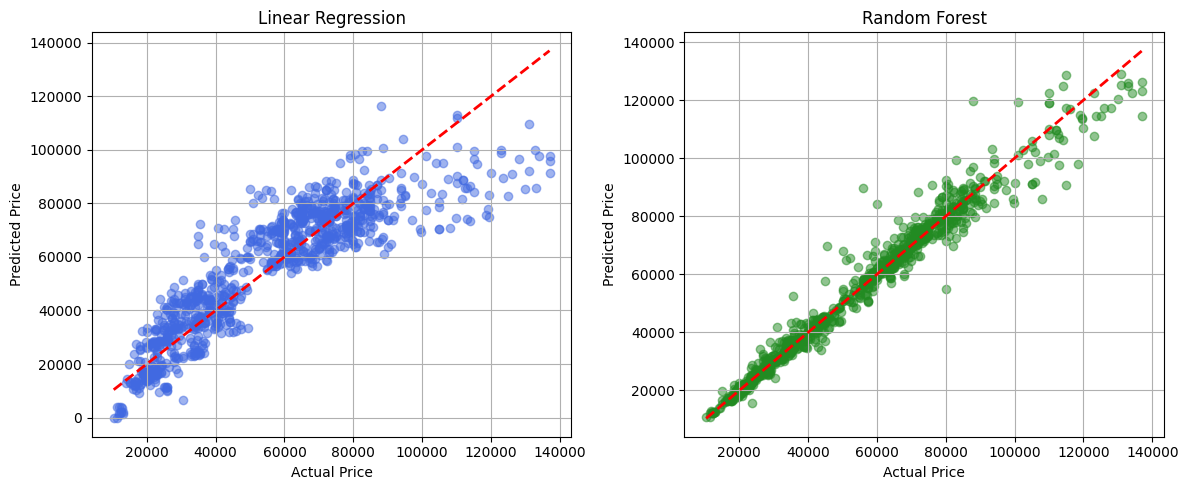

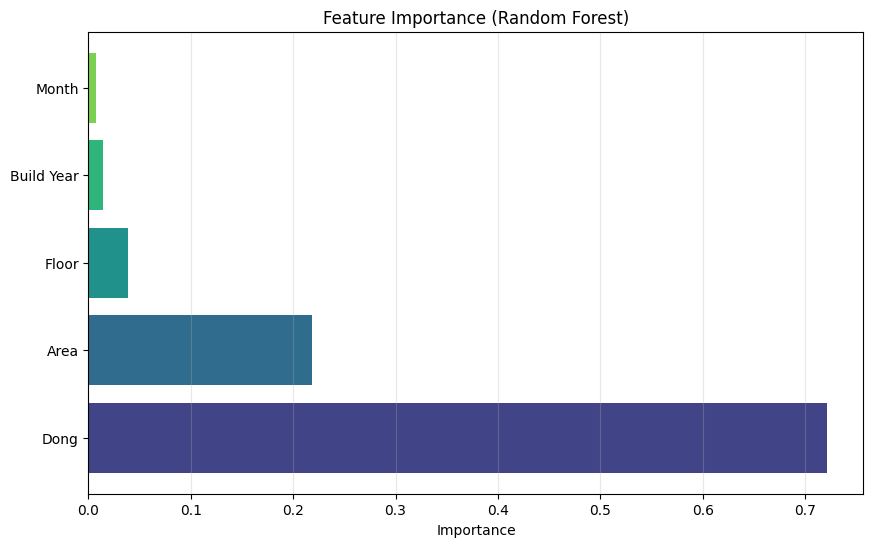


6. 새로운 아파트 가격 예측
예측 조건:
- 법정동: 송도동
- 전용면적: 84.5m²
- 층: 15층
- 건축년도: 2020년
- 거래월: 10월

선형회귀 예측: 77,484만원
랜덤포레스트 예측: 67,606만원

머신러닝 완료!


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

# 머신러닝
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

df = pd.read_csv('incheon_yeonsu_2024_cleaned.csv')

print("=" * 60)
print("머신러닝: 아파트 거래금액 예측 모델")
print("=" * 60)

# 1. 데이터 준비
print("\n1. 데이터 준비")

dong_mapping = {dong: idx for idx, dong in enumerate(df['법정동'].unique())}
df['법정동_encoded'] = df['법정동'].map(dong_mapping)

features = ['법정동_encoded', '전용면적_숫자', '층_숫자', '건축년도_숫자', '거래월']
X = df[features]
y = df['거래금액_숫자']

print(f"전체 데이터: {len(df)}건")
print(f"특성: {features}")
print(f"타겟: 거래금액_숫자")

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n학습 데이터: {len(X_train)}건")
print(f"테스트 데이터: {len(X_test)}건")

# 3. 모델 학습
print("\n" + "=" * 60)
print("2. 모델 학습")
print("=" * 60)

# 선형회귀
print("\n[1] 선형회귀 학습 중...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"RMSE: {lr_rmse:,.0f}만원")
print(f"MAE: {lr_mae:,.0f}만원")
print(f"R2 Score: {lr_r2:.4f}")

# 랜덤포레스트
print("\n[2] 랜덤포레스트 학습 중...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"RMSE: {rf_rmse:,.0f}만원")
print(f"MAE: {rf_mae:,.0f}만원")
print(f"R2 Score: {rf_r2:.4f}")

# 4. 모델 비교
print("\n" + "=" * 60)
print("3. 모델 성능 비교")
print("=" * 60)

comparison = pd.DataFrame({
    '모델': ['선형회귀', '랜덤포레스트'],
    'RMSE': [lr_rmse, rf_rmse],
    'MAE': [lr_mae, rf_mae],
    'R2': [lr_r2, rf_r2]
})
print(comparison.to_string(index=False))

# 5. 특성 중요도
print("\n" + "=" * 60)
print("4. 특성 중요도 (랜덤포레스트)")
print("=" * 60)

feature_importance = pd.DataFrame({
    '특성': features,
    '중요도': rf_model.feature_importances_
}).sort_values('중요도', ascending=False)

print(feature_importance.to_string(index=False))

# 6. 예측 vs 실제 시각화
print("\n" + "=" * 60)
print("5. 예측 결과 시각화")
print("=" * 60)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_pred, alpha=0.5, color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest')
plt.grid(True)

plt.tight_layout()
plt.savefig('11_ml_prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. 특성 중요도 시각화 (영문 변환)
feature_names_eng = ['Dong', 'Area', 'Floor', 'Build Year', 'Month']
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_names_eng)))
plt.barh(feature_names_eng, feature_importance['중요도'], color=colors)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.grid(axis='x', alpha=0.3)
plt.savefig('12_ml_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. 새로운 데이터 예측 테스트
print("\n" + "=" * 60)
print("6. 새로운 아파트 가격 예측")
print("=" * 60)

new_data = pd.DataFrame({
    '법정동_encoded': [dong_mapping['송도동']],
    '전용면적_숫자': [84.5],
    '층_숫자': [15],
    '건축년도_숫자': [2020],
    '거래월': [10]
})

lr_new_pred = lr_model.predict(new_data)[0]
rf_new_pred = rf_model.predict(new_data)[0]

print("예측 조건:")
print("- 법정동: 송도동")
print("- 전용면적: 84.5m²")
print("- 층: 15층")
print("- 건축년도: 2020년")
print("- 거래월: 10월")
print(f"\n선형회귀 예측: {lr_new_pred:,.0f}만원")
print(f"랜덤포레스트 예측: {rf_new_pred:,.0f}만원")

print("\n머신러닝 완료!")
